In [40]:
import joblib
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the processed dataset
df = pd.read_csv("Processed_Bosch_Dataset.csv")

In [4]:
# Load the scaler from EDA
scaler = joblib.load("scaler.pkl")

In [6]:
# Ensure the same feature set used in EDA & LSTM
features = ["Calibration_Interval_Years", "Months_Remaining", "Days_Since_Last_Calibration", "Days_Until_Next_Calibration"]
df[features] = scaler.transform(df[features])

In [7]:
print("\n Successfully loaded & applied the scaler from EDA!")


 Successfully loaded & applied the scaler from EDA!


In [9]:
# Select relevant features for anomaly detection
anomaly_features = ["Calibration_Interval_Years", "Months_Remaining", "Days_Since_Last_Calibration", "Days_Until_Next_Calibration"]
df_anomaly = df[anomaly_features]

In [32]:
# Train Isolation Forest Model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df["Anomaly_Score"] = iso_forest.fit_predict(df_anomaly)

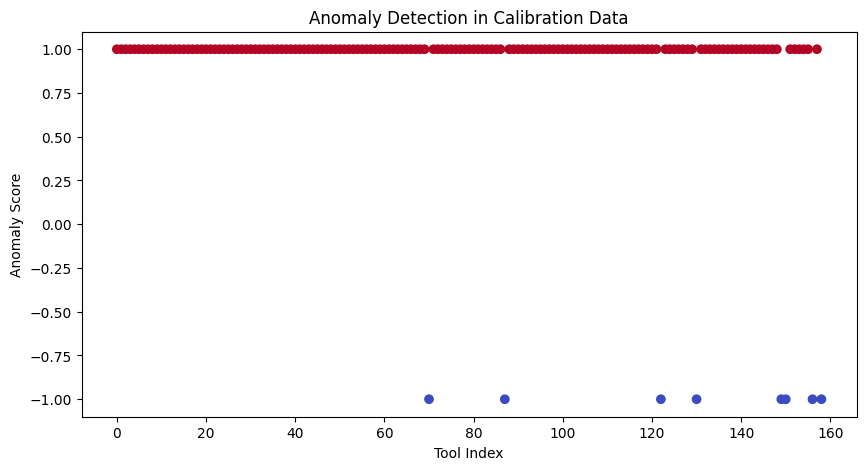

In [33]:
# Visualize Anomalies
plt.figure(figsize=(10,5))
plt.scatter(df.index, df["Anomaly_Score"], c=df["Anomaly_Score"], cmap="coolwarm")
plt.title("Anomaly Detection in Calibration Data")
plt.xlabel("Tool Index")
plt.ylabel("Anomaly Score")
plt.show()

In [13]:
# Save flagged anomalies
anomalies = df[df["Anomaly_Score"] == -1]
anomalies.to_csv("Detected_Anomalies_Isolation_Forest.csv", index=False)

In [14]:
print("\n Anomaly Detection using Isolation Forest Complete! Overdue tools flagged.")


 Anomaly Detection using Isolation Forest Complete! Overdue tools flagged.


In [17]:
#Split Data for Autoencoder Training
X_train, X_test = train_test_split(df_anomaly, test_size=0.2, random_state=42)

In [18]:
# Build Autoencoder Model
autoencoder = Sequential([
    Dense(32, activation="relu", input_shape=(len(anomaly_features),)),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(len(anomaly_features), activation="linear")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compile Model
autoencoder.compile(optimizer="adam", loss="mse")

In [20]:
# Train Autoencoder
history = autoencoder.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=50, batch_size=16, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1019 - val_loss: 0.0881
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0692 - val_loss: 0.0611
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0504 - val_loss: 0.0439
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0310 - val_loss: 0.0356
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0299 - val_loss: 0.0306
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0231 - val_loss: 0.0262
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0168 - val_loss: 0.0232
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0250 - val_loss: 0.0198
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0211 - val_loss: 0.0161
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0160 - val_loss: 0.0126
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - val_loss: 0.0095
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129 - val_loss: 0.0068
E

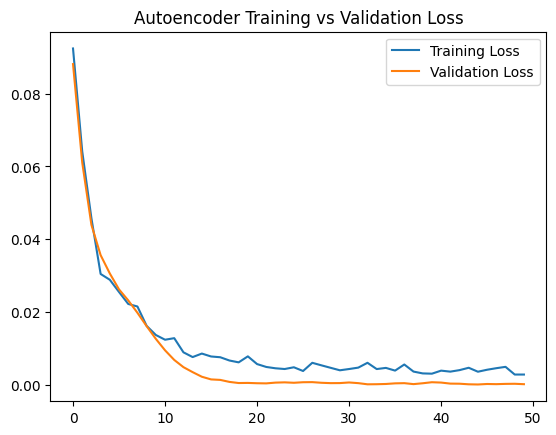

In [21]:
# Plot Training vs Validation Loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Autoencoder Training vs Validation Loss")
plt.show()

In [34]:
# Get Reconstruction Error (Higher Error = Anomaly)
reconstruction_errors = ((df_anomaly - autoencoder.predict(df_anomaly))**2).mean(axis=1)
threshold = reconstruction_errors.quantile(0.95)  # Top 5% as anomalies
df["Anomaly_Score_AE"] = (reconstruction_errors > threshold).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [35]:
# Save Autoencoder-Detected Anomalies
df[df["Anomaly_Score_AE"] == 1].to_csv("Detected_Anomalies_Autoencoder.csv", index=False)

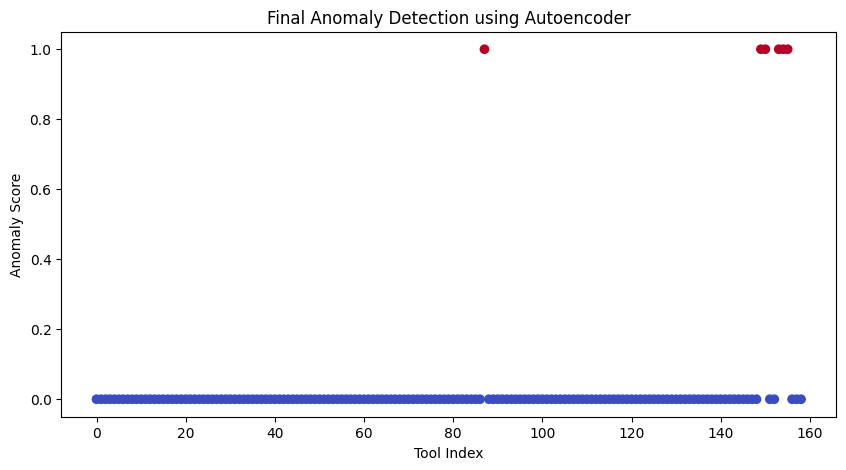

In [43]:
# Scatter Plot of Anomalies
plt.figure(figsize=(10,5))
plt.scatter(df.index, df["Anomaly_Score_AE"], c=df["Anomaly_Score_AE"], cmap="coolwarm")
plt.title("Final Anomaly Detection using Autoencoder")
plt.xlabel("Tool Index")
plt.ylabel("Anomaly Score")
plt.show()

In [45]:
# Show detailed information of flagged anomalies
print("\n Autoencoder Detected Anomalies:\n")
print(df[df["Anomaly_Score_AE"] == 1][["Tool_Description", "Days_Since_Last_Calibration", "Days_Until_Next_Calibration", "Months_Remaining"]])



 Autoencoder Detected Anomalies:

             Tool_Description  Days_Since_Last_Calibration  \
87   Tachometer (non-contact)                    -0.039116   
149     (3.C.1) Torque Wrench                    -0.039082   
150     (3.C.2) Torque Wrench                    -0.039083   
153         (3.D.1) Flowmeter                    -0.039363   
154         (3.D.2) Flowmeter                    -0.039363   
155         (3.D.3) Flowmeter                    -0.039363   

     Days_Until_Next_Calibration  Months_Remaining  
87                      0.360553          0.380994  
149                     0.360191          0.370125  
150                     0.360192          0.370152  
153                     0.360478          0.378734  
154                     0.360478          0.378734  
155                     0.360478          0.378734  


In [36]:
print("\n Autoencoder Anomaly Detection Complete! Overdue tools flagged.")


 Autoencoder Anomaly Detection Complete! Overdue tools flagged.


In [38]:
# Compare Results
anomaly_counts = df[["Anomaly_Score", "Anomaly_Score_AE"]].apply(pd.Series.value_counts)
print("\n Anomaly Counts Comparison:\n", anomaly_counts)


 Anomaly Counts Comparison:
     Anomaly_Score  Anomaly_Score_AE
-1            8.0               NaN
 0            NaN             153.0
 1          151.0               6.0


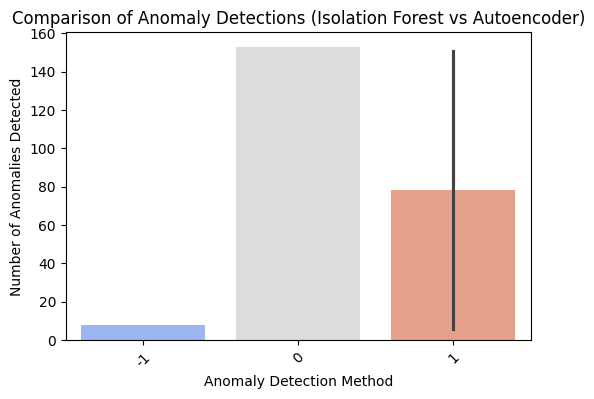

In [41]:
# Visualize Comparison
plt.figure(figsize=(6, 4))
sns.barplot(data=anomaly_counts.T, palette="coolwarm")
plt.title("Comparison of Anomaly Detections (Isolation Forest vs Autoencoder)")
plt.xlabel("Anomaly Detection Method")
plt.ylabel("Number of Anomalies Detected")
plt.xticks(rotation=45)
plt.show()